<a href="https://colab.research.google.com/github/joydeep1007/Treee-classification/blob/master/better_tree_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()
# Select your Tree_Species_Dataset.zip file when prompted

# Extract the dataset
import zipfile
with zipfile.ZipFile('Tree_Species_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

# Verify extraction
import os
print(os.listdir('data/'))

Saving Tree_Species_Dataset.zip to Tree_Species_Dataset.zip
['Tree_Species_Dataset']


In [7]:
DATA_DIR = 'data/Tree_Species_Dataset'
IMG_SIZE = 224
BATCH_SIZE = 32

# Explore dataset structure
print("🌳 Tree Species Dataset Analysis")
print("=" * 50)

species_counts = {}
total_images = 0

# Count images per species
for species in os.listdir(DATA_DIR):
    species_path = os.path.join(DATA_DIR, species)
    if os.path.isdir(species_path):
        image_files = [f for f in os.listdir(species_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        species_counts[species] = len(image_files)
        total_images += len(image_files)

print(f"Total number of species: {len(species_counts)}")
print(f"Total number of images: {total_images}")
print(f"Average images per species: {total_images / len(species_counts):.1f}")
print(f"Min images per species: {min(species_counts.values())}")
print(f"Max images per species: {max(species_counts.values())}")

# Create DataFrame for better visualization
df_species = pd.DataFrame(list(species_counts.items()), columns=['Species', 'Count'])
df_species = df_species.sort_values('Count', ascending=False)
print("\nTop 10 species by image count:")
print(df_species.head(10))

🌳 Tree Species Dataset Analysis
Total number of species: 30
Total number of images: 1600
Average images per species: 53.3
Min images per species: 50
Max images per species: 150

Top 10 species by image count:
      Species  Count
29      other    150
0    gulmohor     50
2         vad     50
3      kesudo     50
4    sonmahor     50
1      cactus     50
6       jamun     50
7        bili     50
8   pilikaren     50
9      champa     50


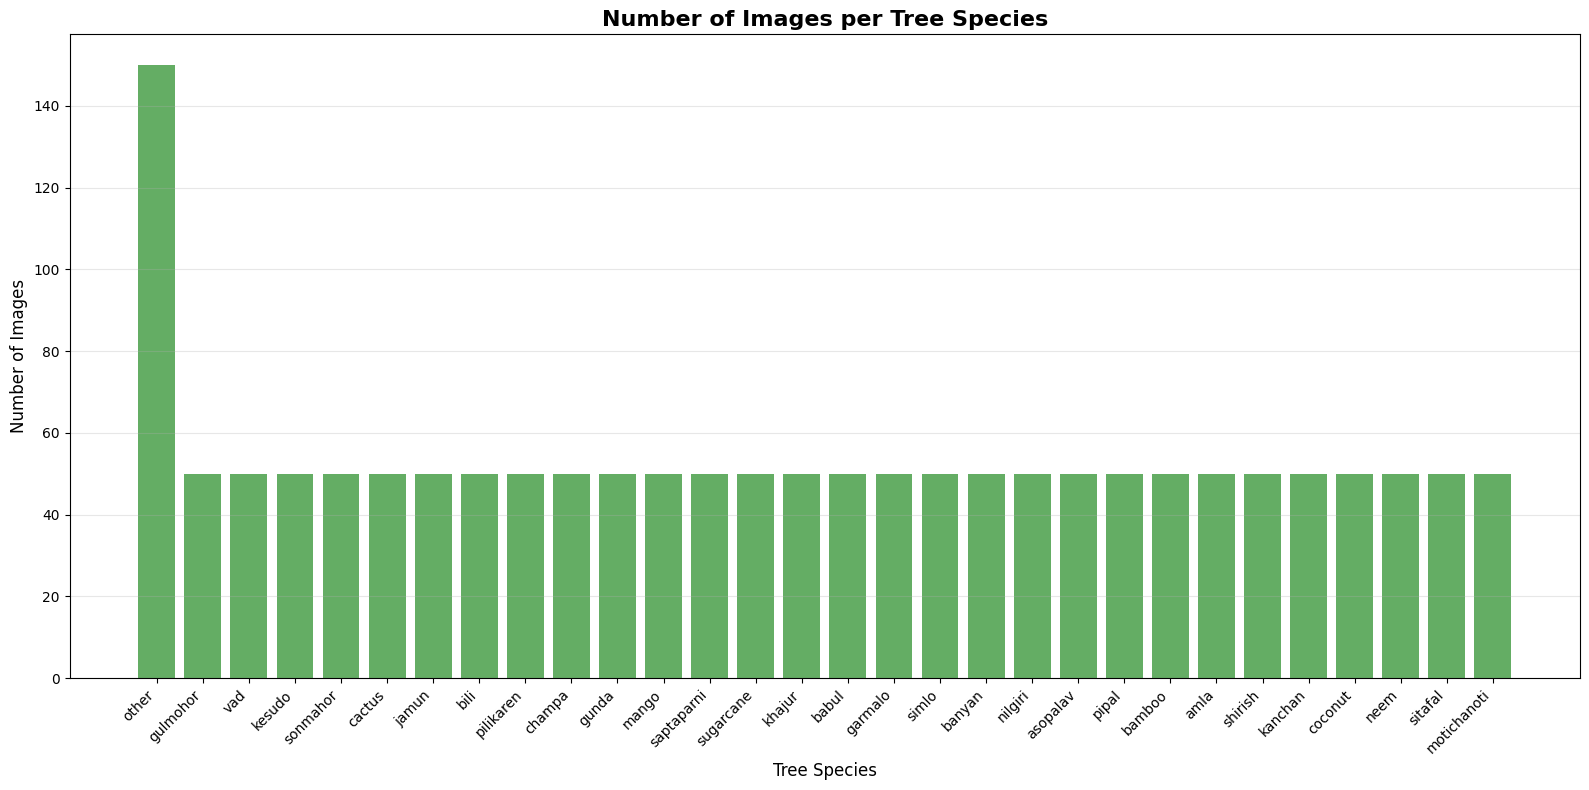

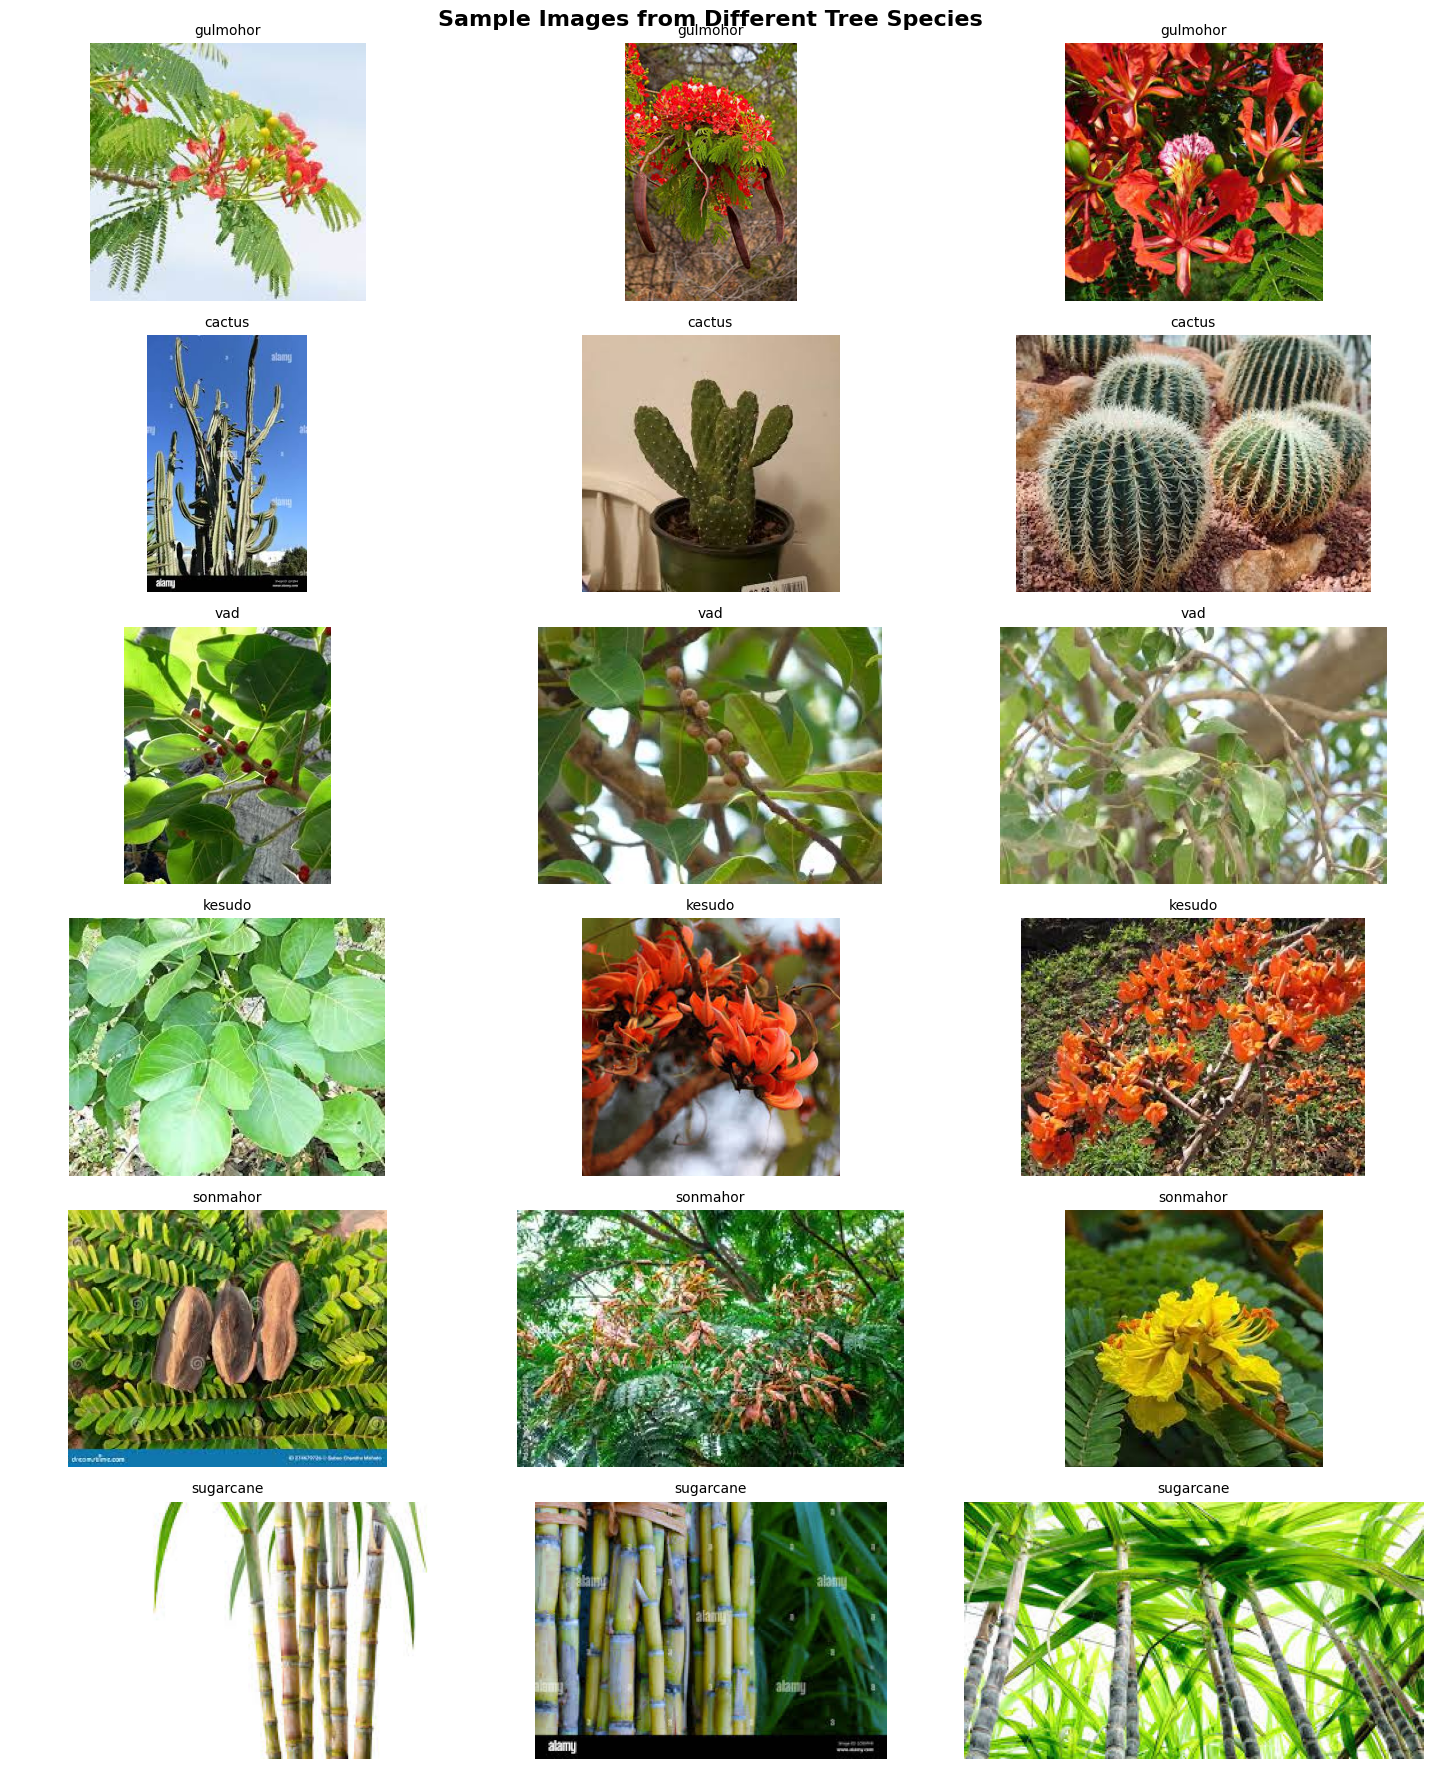

In [8]:
plt.figure(figsize=(16, 8))
plt.bar(df_species['Species'], df_species['Count'], color='forestgreen', alpha=0.7)
plt.title('Number of Images per Tree Species', fontsize=16, fontweight='bold')
plt.xlabel('Tree Species', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display sample images from different species
def show_sample_images(data_dir, species_list, num_samples=3):
    fig, axes = plt.subplots(len(species_list), num_samples, figsize=(15, len(species_list) * 3))
    fig.suptitle('Sample Images from Different Tree Species', fontsize=16, fontweight='bold')

    for i, species in enumerate(species_list):
        species_path = os.path.join(data_dir, species)
        image_files = [f for f in os.listdir(species_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(species_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{species}', fontsize=10)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Show samples from first 6 species
sample_species = list(species_counts.keys())[:6]
show_sample_images(DATA_DIR, sample_species)

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.2,    # Random horizontal shift
    height_shift_range=0.2,   # Random vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest',      # Fill mode for transformations
    validation_split=0.2      # 80% train, 20% validation
)

# Only rescaling for validation (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Create validation data generator
val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Get class information
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Steps per epoch (training): {train_generator.samples // BATCH_SIZE}")
print(f"Steps per epoch (validation): {val_generator.samples // BATCH_SIZE}")
print(f"\nClass names: {class_names}")

Found 1280 images belonging to 30 classes.
Found 320 images belonging to 30 classes.
Number of classes: 30
Training samples: 1280
Validation samples: 320
Steps per epoch (training): 40
Steps per epoch (validation): 10

Class names: ['amla', 'asopalav', 'babul', 'bamboo', 'banyan', 'bili', 'cactus', 'champa', 'coconut', 'garmalo', 'gulmohor', 'gunda', 'jamun', 'kanchan', 'kesudo', 'khajur', 'mango', 'motichanoti', 'neem', 'nilgiri', 'other', 'pilikaren', 'pipal', 'saptaparni', 'shirish', 'simlo', 'sitafal', 'sonmahor', 'sugarcane', 'vad']


In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization

# Build custom CNN model from scratch
def create_custom_cnn_model(input_shape, num_classes):
    """
    Create a custom CNN architecture for tree species classification
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.InputLayer(input_shape=input_shape),

        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fifth Convolutional Block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten and Dense layers
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the custom CNN model
print("🏗️ Building custom CNN model from scratch...")
input_shape = (IMG_SIZE, IMG_SIZE, 3)

model = create_custom_cnn_model(input_shape, num_classes)

print("✅ Custom CNN model created successfully!")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Total parameters: {model.count_params():,}")

# Display model architecture
print("\n📋 Model Architecture:")
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model,
    to_file='results/model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=150
)
print("\n📊 Model architecture diagram saved to 'results/model_architecture.png'")

🏗️ Building custom CNN model from scratch...
✅ Custom CNN model created successfully!
Input shape: (224, 224, 3)
Number of classes: 30
Total parameters: 31,077,310

📋 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 31,077,310 (118.55 MB)

 Trainable params: 31,072,254 (118.53 MB)

 Non-trainable params: 5,056 (19.75 KB)

FileNotFoundError: [Errno 2] No such file or directory: 'results/model_architecture.png'

In [11]:
# Compile the custom CNN model
model.compile(
    optimizer=Adam(learning_rate=0.001),    # Adam optimizer with learning rate 0.001
    loss='categorical_crossentropy',        # Categorical crossentropy for multi-class
    metrics=['accuracy', 'top_k_categorical_accuracy']  # Track accuracy and top-5 accuracy
)

print("✅ Custom CNN model compiled successfully!")

# Create directories for saving models and results
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Define callbacks for training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',      # Monitor validation accuracy
        patience=15,                 # Stop if no improvement for 15 epochs (increased for custom model)
        restore_best_weights=True,   # Restore best weights
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',          # Monitor validation loss
        factor=0.3,                  # Reduce LR by factor of 0.3
        patience=7,                  # Wait 7 epochs before reducing
        min_lr=1e-7,                 # Minimum learning rate
        verbose=1
    ),

    # Save the best model during training
    ModelCheckpoint(
        'models/best_custom_cnn_classifier.h5',  # Save path
        monitor='val_accuracy',                   # Monitor validation accuracy
        save_best_only=True,                     # Save only the best model
        verbose=1
    )
]

print("📋 Callbacks configured for custom CNN:")
for callback in callbacks:
    print(f"- {callback.__class__.__name__}")

# Display training configuration
print(f"\n🎯 Training Configuration:")
print(f"- Model Type: Custom CNN (Built from Scratch)")
print(f"- Total Parameters: {model.count_params():,}")
print(f"- Input Shape: {input_shape}")
print(f"- Number of Classes: {num_classes}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Learning Rate: 0.001")

✅ Custom CNN model compiled successfully!
📋 Callbacks configured for custom CNN:
- EarlyStopping
- ReduceLROnPlateau
- ModelCheckpoint

🎯 Training Configuration:
- Model Type: Custom CNN (Built from Scratch)
- Total Parameters: 31,077,310
- Input Shape: (224, 224, 3)
- Number of Classes: 30
- Batch Size: 32
- Learning Rate: 0.001


In [12]:
EPOCHS = 100  # Increased epochs for training from scratch

print("🚀 Starting custom CNN model training...")
print(f"Training for {EPOCHS} epochs")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Model parameters: {model.count_params():,}")
print("=" * 60)

# Train the custom CNN model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Custom CNN training completed!")

# Get training results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_top5_acc = history.history['top_k_categorical_accuracy'][-1]
final_val_top5_acc = history.history['val_top_k_categorical_accuracy'][-1]

print(f"\n📊 Final Training Results:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Training Top-5 Accuracy: {final_top5_acc:.4f}")
print(f"Validation Top-5 Accuracy: {final_val_top5_acc:.4f}")

# Calculate best validation accuracy achieved
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

🚀 Starting custom CNN model training...
Training for 100 epochs
Training samples: 1280
Validation samples: 320
Model parameters: 31,077,310
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.0411 - loss: 4.4865 - top_k_categorical_accuracy: 0.1976
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 660ms/step - accuracy: 0.0412 - loss: 4.4814 - top_k_categorical_accuracy: 0.1979 - val_accuracy: 0.0938 - val_loss: 4.5748 - val_top_k_categorical_accuracy: 0.2156 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.0693 - loss: 3.9826 - top_k_categorical_accuracy: 0.2409
Epoch 2: val_accuracy did not improve from 0.09375
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 486ms/step - accuracy: 0.0694 - loss: 3.9827 - top_k_categorical_accuracy: 0.2409 - val_accuracy: 0.0312 - val_loss: 3.4593 - val_top_k_categorical_accuracy: 0.1625 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.0822 - loss: 3.8760 - top_k_categorical_accuracy: 0.2505
Epoch 3: val_accuracy did not improve from 0.09375
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - accuracy: 0.0821 - loss: 3.8759 - top_k_categorical_accuracy: 0.2507 - val_accuracy: 0.0250 - val_loss: 3.8253 - val_top_k_categorical_accuracy: 0.1531 - learning_rat

40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 496ms/step - accuracy: 0.1675 - loss: 3.0583 - top_k_categorical_accuracy: 0.4601 - val_accuracy: 0.1187 - val_loss: 3.4954 - val_top_k_categorical_accuracy: 0.2875 - learning_rate: 3.0000e-04
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.1472 - loss: 3.0391 - top_k_categorical_accuracy: 0.4595
Epoch 12: val_accuracy did not improve from 0.11875
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 483ms/step - accuracy: 0.1474 - loss: 3.0380 - top_k_categorical_accuracy: 0.4597 - val_accuracy: 0.1187 - val_loss: 3.4236 - val_top_k_categorical_accuracy: 0.2812 - learning_rate: 3.0000e-04
Epoch 13/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.1838 - loss: 2.8904 - top_k_categorical_accuracy: 0.5029
Epoch 13: val_accuracy improved from 0.11875 to 0.14375, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 627ms/step - accuracy: 0.1833 - loss: 2.8917 - top_k_categorical_accuracy: 0.5025 - val_accuracy: 0.1437 - val_loss: 3.2430 - val_top_k_categorical_accuracy: 0.3219 - learning_rate: 3.0000e-04
Epoch 14/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.1975 - loss: 2.9124 - top_k_categorical_accuracy: 0.4950
Epoch 14: val_accuracy improved from 0.14375 to 0.17812, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 526ms/step - accuracy: 0.1972 - loss: 2.9120 - top_k_categorical_accuracy: 0.4948 - val_accuracy: 0.1781 - val_loss: 3.0597 - val_top_k_categorical_accuracy: 0.3844 - learning_rate: 3.0000e-04
Epoch 15/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.1969 - loss: 2.8376 - top_k_categorical_accuracy: 0.4957
Epoch 15: val_accuracy improved from 0.17812 to 0.20312, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.1968 - loss: 2.8385 - top_k_categorical_accuracy: 0.4961 - val_accuracy: 0.2031 - val_loss: 2.9847 - val_top_k_categorical_accuracy: 0.4219 - learning_rate: 3.0000e-04
Epoch 16/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.1695 - loss: 2.9088 - top_k_categorical_accuracy: 0.4949
Epoch 16: val_accuracy did not improve from 0.20312
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - accuracy: 0.1698 - loss: 2.9076 - top_k_categorical_accuracy: 0.4953 - val_accuracy: 0.1937 - val_loss: 2.9309 - val_top_k_categorical_accuracy: 0.4344 - learning_rate: 3.0000e-04
Epoch 17/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.1797 - loss: 2.9472 - top_k_categorical_accuracy: 0.4935
Epoch 17: val_accuracy improved from 0.20312 to 0.21563, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.1799 - loss: 2.9453 - top_k_categorical_accuracy: 0.4941 - val_accuracy: 0.2156 - val_loss: 2.8326 - val_top_k_categorical_accuracy: 0.5094 - learning_rate: 3.0000e-04
Epoch 18/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.1808 - loss: 2.8231 - top_k_categorical_accuracy: 0.5142
Epoch 18: val_accuracy improved from 0.21563 to 0.25000, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.1809 - loss: 2.8230 - top_k_categorical_accuracy: 0.5143 - val_accuracy: 0.2500 - val_loss: 2.7203 - val_top_k_categorical_accuracy: 0.4969 - learning_rate: 3.0000e-04
Epoch 19/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.2058 - loss: 2.7198 - top_k_categorical_accuracy: 0.5499
Epoch 19: val_accuracy improved from 0.25000 to 0.27812, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.2056 - loss: 2.7223 - top_k_categorical_accuracy: 0.5491 - val_accuracy: 0.2781 - val_loss: 2.6310 - val_top_k_categorical_accuracy: 0.5844 - learning_rate: 3.0000e-04
Epoch 20/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.1986 - loss: 2.7745 - top_k_categorical_accuracy: 0.5376
Epoch 20: val_accuracy improved from 0.27812 to 0.28750, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 515ms/step - accuracy: 0.1987 - loss: 2.7743 - top_k_categorical_accuracy: 0.5376 - val_accuracy: 0.2875 - val_loss: 2.4743 - val_top_k_categorical_accuracy: 0.6500 - learning_rate: 3.0000e-04
Epoch 21/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.2407 - loss: 2.6896 - top_k_categorical_accuracy: 0.5587
Epoch 21: val_accuracy did not improve from 0.28750
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - accuracy: 0.2404 - loss: 2.6900 - top_k_categorical_accuracy: 0.5584 - val_accuracy: 0.2844 - val_loss: 2.5665 - val_top_k_categorical_accuracy: 0.6406 - learning_rate: 3.0000e-04
Epoch 22/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.2335 - loss: 2.7573 - top_k_categorical_accuracy: 0.5509
Epoch 22: val_accuracy did not improve from 0.28750
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.2333 - loss: 2.7578 - top_k_categorical_accuracy: 0.5507 - val_accuracy: 0.2438 - val_loss: 2.6243 - val_top_k_categorical_accuracy: 0.6000 - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 640ms/step - accuracy: 0.2295 - loss: 2.7272 - top_k_categorical_accuracy: 0.5647 - val_accuracy: 0.3344 - val_loss: 2.4556 - val_top_k_categorical_accuracy: 0.6500 - learning_rate: 3.0000e-04
Epoch 24/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.2477 - loss: 2.5976 - top_k_categorical_accuracy: 0.5912
Epoch 24: val_accuracy did not improve from 0.33437
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 466ms/step - accuracy: 0.2472 - loss: 2.5997 - top_k_categorical_accuracy: 0.5908 - val_accuracy: 0.2313 - val_loss: 2.6522 - val_top_k_categorical_accuracy: 0.5938 - learning_rate: 3.0000e-04
Epoch 25/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.2223 - loss: 2.6301 - top_k_categorical_accuracy: 0.5885
Epoch 25: val_accuracy did not improve from 0.33437
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.2224 - loss: 2.6318 - top_k_categorical_accuracy: 0.5880 - val_accuracy: 0.2844 - val_loss: 2.5122 - val_top_k_categorical_accuracy: 0.6313 - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 643ms/step - accuracy: 0.3060 - loss: 2.3984 - top_k_categorical_accuracy: 0.6632 - val_accuracy: 0.3406 - val_loss: 2.2921 - val_top_k_categorical_accuracy: 0.6812 - learning_rate: 9.0000e-05
Epoch 39/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3127 - loss: 2.3491 - top_k_categorical_accuracy: 0.6884
Epoch 39: val_accuracy did not improve from 0.34062
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 461ms/step - accuracy: 0.3129 - loss: 2.3487 - top_k_categorical_accuracy: 0.6883 - val_accuracy: 0.3031 - val_loss: 2.3911 - val_top_k_categorical_accuracy: 0.6500 - learning_rate: 9.0000e-05
Epoch 40/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.3068 - loss: 2.3815 - top_k_categorical_accuracy: 0.6789
Epoch 40: val_accuracy did not improve from 0.34062
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - accuracy: 0.3070 - loss: 2.3804 - top_k_categorical_accuracy: 0.6794 - val_accuracy: 0.3063 - val_loss: 2.4151 - val_top_k_categorical_accuracy: 0.6250 - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 649ms/step - accuracy: 0.3380 - loss: 2.2565 - top_k_categorical_accuracy: 0.7234 - val_accuracy: 0.3594 - val_loss: 2.2492 - val_top_k_categorical_accuracy: 0.7094 - learning_rate: 9.0000e-05
Epoch 48/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.3161 - loss: 2.3399 - top_k_categorical_accuracy: 0.6774
Epoch 48: val_accuracy did not improve from 0.35938
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - accuracy: 0.3164 - loss: 2.3382 - top_k_categorical_accuracy: 0.6779 - val_accuracy: 0.3156 - val_loss: 2.3758 - val_top_k_categorical_accuracy: 0.6938 - learning_rate: 9.0000e-05
Epoch 49/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.3355 - loss: 2.2346 - top_k_categorical_accuracy: 0.7118
Epoch 49: val_accuracy did not improve from 0.35938
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - accuracy: 0.3355 - loss: 2.2345 - top_k_categorical_accuracy: 0.7118 - val_accuracy: 0.3406 - val_loss: 2.3469 - val_top_k_categorical_accuracy: 0.6875 - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 660ms/step - accuracy: 0.3752 - loss: 2.1790 - top_k_categorical_accuracy: 0.7220 - val_accuracy: 0.3625 - val_loss: 2.3491 - val_top_k_categorical_accuracy: 0.6938 - learning_rate: 9.0000e-05
Epoch 55/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.3445 - loss: 2.1471 - top_k_categorical_accuracy: 0.7320
Epoch 55: val_accuracy improved from 0.36250 to 0.37500, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 637ms/step - accuracy: 0.3447 - loss: 2.1467 - top_k_categorical_accuracy: 0.7323 - val_accuracy: 0.3750 - val_loss: 2.1858 - val_top_k_categorical_accuracy: 0.7437 - learning_rate: 2.7000e-05
Epoch 56/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.3878 - loss: 2.0813 - top_k_categorical_accuracy: 0.7477
Epoch 56: val_accuracy improved from 0.37500 to 0.38438, saving model to models/best_custom_cnn_classifier.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 509ms/step - accuracy: 0.3874 - loss: 2.0818 - top_k_categorical_accuracy: 0.7476 - val_accuracy: 0.3844 - val_loss: 2.2179 - val_top_k_categorical_accuracy: 0.7156 - learning_rate: 2.7000e-05
Epoch 57/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3569 - loss: 2.1337 - top_k_categorical_accuracy: 0.7551
Epoch 57: val_accuracy did not improve from 0.38438
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 460ms/step - accuracy: 0.3570 - loss: 2.1332 - top_k_categorical_accuracy: 0.7552 - val_accuracy: 0.3656 - val_loss: 2.2158 - val_top_k_categorical_accuracy: 0.7188 - learning_rate: 2.7000e-05
Epoch 58/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3556 - loss: 2.0619 - top_k_categorical_accuracy: 0.7747
Epoch 58: val_accuracy did not improve from 0.38438
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - accuracy: 0.3557 - loss: 2.0633 - top_k_categorical_accuracy: 0.7742 - val_accuracy: 0.3625 - val_loss: 2.2591 - val_top_k_categorical_accuracy: 0.6938 - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 779ms/step - accuracy: 0.3707 - loss: 2.0956 - top_k_categorical_accuracy: 0.7676 - val_accuracy: 0.3875 - val_loss: 2.2957 - val_top_k_categorical_accuracy: 0.7094 - learning_rate: 2.7000e-05
Epoch 63/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3719 - loss: 2.1713 - top_k_categorical_accuracy: 0.7292
Epoch 63: val_accuracy did not improve from 0.38750
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 471ms/step - accuracy: 0.3719 - loss: 2.1699 - top_k_categorical_accuracy: 0.7294 - val_accuracy: 0.3781 - val_loss: 2.2982 - val_top_k_categorical_accuracy: 0.7000 - learning_rate: 8.1000e-06
Epoch 64/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.4062 - loss: 1.9893 - top_k_categorical_accuracy: 0.7713
Epoch 64: val_accuracy did not improve from 0.38750
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - accuracy: 0.4064 - loss: 1.9895 - top_k_categorical_accuracy: 0.7712 - val_accuracy: 0.3500 - val_loss: 2.3019 - val_top_k_categorical_accuracy: 0.7094 - 

In [14]:
print("\n🔧 Optional: Continue training with reduced learning rate...")

# Check if we can improve further with lower learning rate
if final_val_acc < 0.90:  # If validation accuracy is less than 90%
    print("Validation accuracy is below 90%. Continuing training with lower learning rate...")

    # Compile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # 10x lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )

    # Continue training with lower learning rate
    ADDITIONAL_EPOCHS = 20

    additional_history = model.fit(
        train_generator,
        epochs=ADDITIONAL_EPOCHS,
        validation_data=val_generator,
        verbose=1
    )

    # Update history by combining both training phases
    for key in additional_history.history.keys():
        history.history[key].extend(additional_history.history[key])

    # Get updated results
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"Updated Training Accuracy: {final_train_acc:.4f}")
    print(f"Updated Validation Accuracy: {final_val_acc:.4f}")

else:
    print(f"Validation accuracy is {final_val_acc:.4f} (≥90%). No additional training needed.")

print("✅ Training process completed!")

# Display layer information
print(f"\n🧠 Model Architecture Summary:")
print(f"- Total Layers: {len(model.layers)}")
print(f"- Convolutional Layers: {len([l for l in model.layers if 'conv' in l.name])}")
print(f"- Dense Layers: {len([l for l in model.layers if 'dense' in l.name])}")
print(f"- Total Parameters: {model.count_params():,}")

# Calculate model size
model_size_mb = model.count_params() * 4 / (1024 * 1024)  # Assuming float32
print(f"- Estimated Model Size: {model_size_mb:.1f} MB")


🔧 Optional: Continue training with reduced learning rate...
Validation accuracy is below 90%. Continuing training with lower learning rate...
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 521ms/step - accuracy: 0.4259 - loss: 1.9428 - top_k_categorical_accuracy: 0.7830 - val_accuracy: 0.3656 - val_loss: 2.3638 - val_top_k_categorical_accuracy: 0.6656
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 464ms/step - accuracy: 0.4235 - loss: 1.9587 - top_k_categorical_accuracy: 0.7762 - val_accuracy: 0.4125 - val_loss: 2.2214 - val_top_k_categorical_accuracy: 0.7625
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - accuracy: 0.4585 - loss: 1.8618 - top_k_categorical_accuracy: 0.8008 - val_accuracy: 0.3750 - val_loss: 2.1552 - val_top_k_categorical_accuracy: 0.7437
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.4534 - loss: 1.8031 - top_k_categorical_accuracy: 0.8118 - val_accuracy: 0.3187 - val_loss: 2.4347 - val_top_k_categorical_accuracy: 0.6562
Epoch 5/20
40/40 ━━━━━━━━━━━━

In [15]:
print("📊 Evaluating model performance...")

# Get predictions on validation set
val_steps = val_generator.samples // BATCH_SIZE + 1
predictions = model.predict(val_generator, steps=val_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes[:len(predicted_classes)]

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_names,
    output_dict=True
)

print("\n📈 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Create a DataFrame for better visualization of the report
report_df = pd.DataFrame(report).transpose()
print("\nDetailed metrics by class:")
print(report_df.round(4))

📊 Evaluating model performance...
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step

Validation Accuracy: 0.3438

📈 Classification Report:
              precision    recall  f1-score   support

        amla       0.33      0.50      0.40        10
    asopalav       0.33      0.10      0.15        10
       babul       0.40      0.20      0.27        10
      bamboo       0.67      0.20      0.31        10
      banyan       0.25      0.10      0.14        10
        bili       0.50      0.10      0.17        10
      cactus       0.18      0.20      0.19        10
      champa       0.67      0.40      0.50        10
     coconut       0.24      0.70      0.36        10
     garmalo       0.62      0.50      0.56        10
    gulmohor       0.32      0.60      0.41        10
       gunda       0.00      0.00      0.00        10
       jamun       1.00      0.10      0.18        10
     kanchan       0.89      0.80      0.84        10
      kesudo       0.40      0.20      0.27        10
      

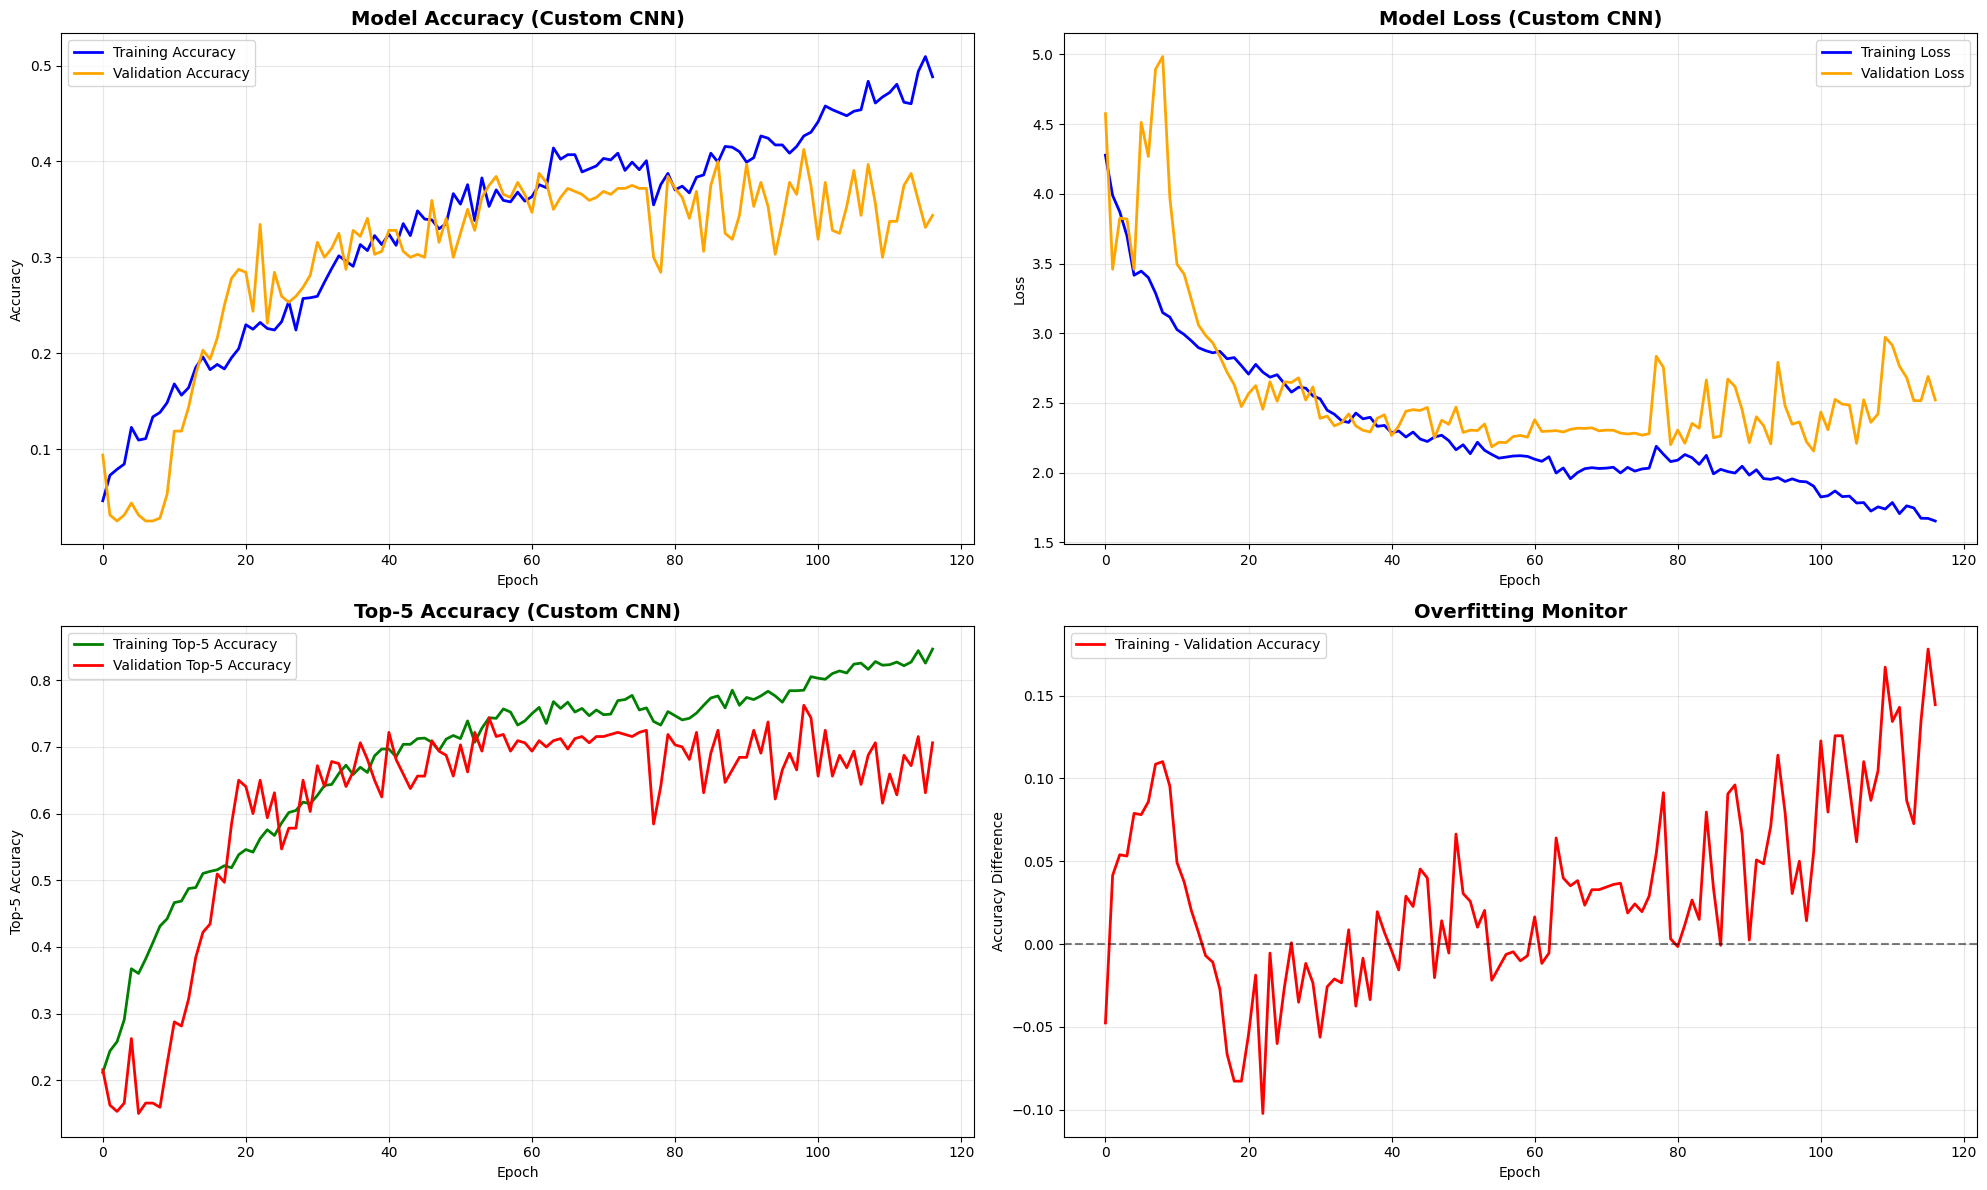

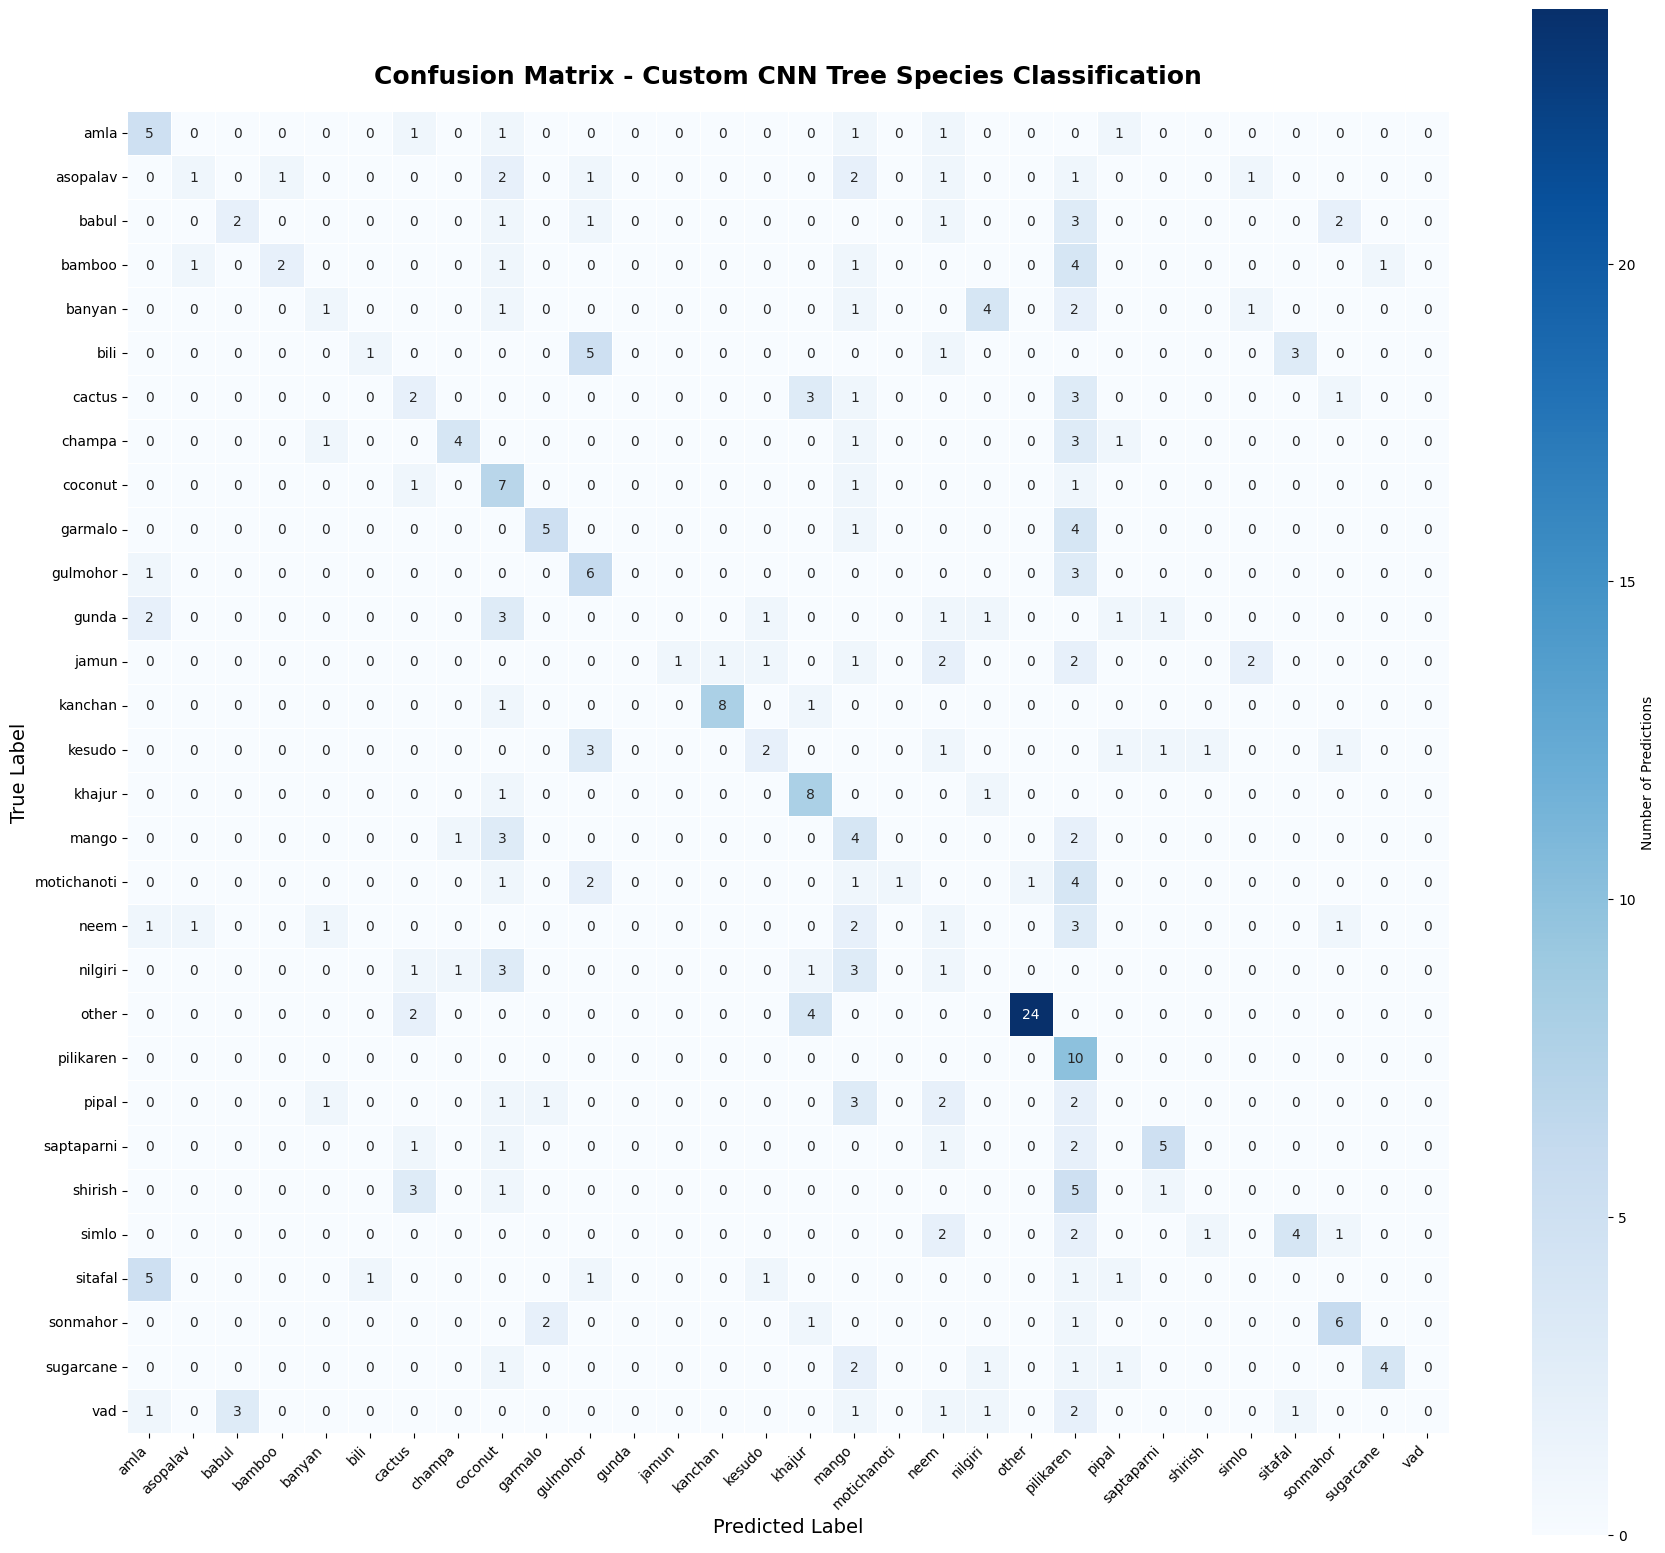

📊 Detailed Per-Class Performance Metrics (Custom CNN):
        Species  Accuracy  Precision  Recall  F1_Score  Total_Samples  \
20        other       0.8     0.9600     0.8    0.8727             30   
13      kanchan       0.8     0.8889     0.8    0.8421             10   
15       khajur       0.8     0.4444     0.8    0.5714             10   
9       garmalo       0.5     0.6250     0.5    0.5556             10   
23   saptaparni       0.5     0.6250     0.5    0.5556             10   
27     sonmahor       0.6     0.5000     0.6    0.5455             10   
28    sugarcane       0.4     0.8000     0.4    0.5333             10   
7        champa       0.4     0.6667     0.4    0.5000             10   
10     gulmohor       0.6     0.3158     0.6    0.4138             10   
0          amla       0.5     0.3333     0.5    0.4000             10   
8       coconut       0.7     0.2414     0.7    0.3590             10   
3        bamboo       0.2     0.6667     0.2    0.3077             10

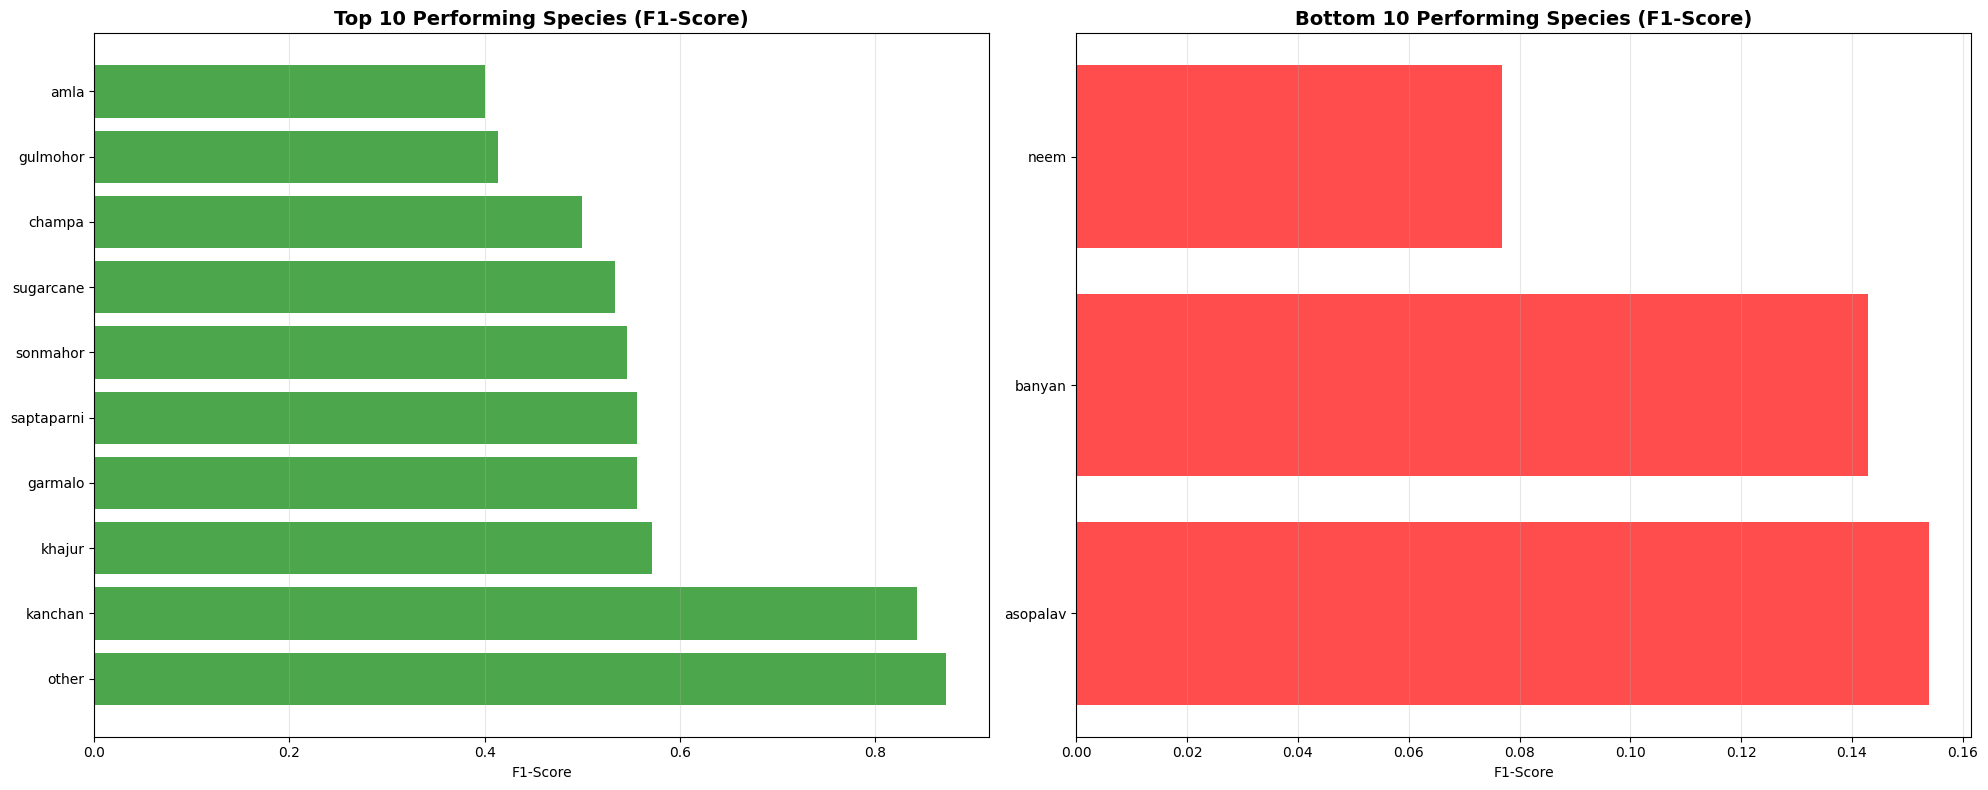


🎯 Overall Custom CNN Performance Summary:
Overall Accuracy: 0.3438
Average Precision: nan
Average Recall: 0.3133
Average F1-Score: nan
Best Class F1-Score: 0.8727 (other)
Worst Class F1-Score: 0.0769 (vad)


In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
ax1.set_title('Model Accuracy (Custom CNN)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax2.set_title('Model Loss (Custom CNN)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot Top-5 accuracy
ax3.plot(history.history['top_k_categorical_accuracy'], label='Training Top-5 Accuracy', linewidth=2, color='green')
ax3.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-5 Accuracy', linewidth=2, color='red')
ax3.set_title('Top-5 Accuracy (Custom CNN)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Top-5 Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot learning rate (if available)
if 'lr' in history.history:
    ax4.plot(history.history['lr'], label='Learning Rate', linewidth=2, color='purple')
    ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.set_yscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    # Plot validation accuracy vs training accuracy difference
    acc_diff = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    ax4.plot(acc_diff, label='Training - Validation Accuracy', linewidth=2, color='red')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/custom_cnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot confusion matrix with enhanced styling
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Number of Predictions'},
           square=True, linewidths=0.5)
plt.title('Confusion Matrix - Custom CNN Tree Species Classification', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('results/custom_cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Enhanced per-class accuracy analysis
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_precision = cm.diagonal() / cm.sum(axis=0)
class_recall = class_accuracy  # Same as accuracy for diagonal
class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall)

performance_df = pd.DataFrame({
    'Species': class_names,
    'Accuracy': class_accuracy,
    'Precision': class_precision,
    'Recall': class_recall,
    'F1_Score': class_f1,
    'Total_Samples': cm.sum(axis=1),
    'Correct_Predictions': cm.diagonal()
}).sort_values('F1_Score', ascending=False)

print("📊 Detailed Per-Class Performance Metrics (Custom CNN):")
print(performance_df.round(4))

# Plot top and bottom performing species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top 10 performing species
top_10 = performance_df.head(10)
ax1.barh(top_10['Species'], top_10['F1_Score'], color='green', alpha=0.7)
ax1.set_title('Top 10 Performing Species (F1-Score)', fontsize=14, fontweight='bold')
ax1.set_xlabel('F1-Score')
ax1.grid(axis='x', alpha=0.3)

# Bottom 10 performing species
bottom_10 = performance_df.tail(10)
ax2.barh(bottom_10['Species'], bottom_10['F1_Score'], color='red', alpha=0.7)
ax2.set_title('Bottom 10 Performing Species (F1-Score)', fontsize=14, fontweight='bold')
ax2.set_xlabel('F1-Score')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('results/species_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Overall performance summary
overall_accuracy = accuracy
overall_precision = np.mean(class_precision)
overall_recall = np.mean(class_recall)
overall_f1 = np.mean(class_f1)

print(f"\n🎯 Overall Custom CNN Performance Summary:")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Average Precision: {overall_precision:.4f}")
print(f"Average Recall: {overall_recall:.4f}")
print(f"Average F1-Score: {overall_f1:.4f}")
print(f"Best Class F1-Score: {performance_df['F1_Score'].max():.4f} ({performance_df.iloc[0]['Species']})")
print(f"Worst Class F1-Score: {performance_df['F1_Score'].min():.4f} ({performance_df.iloc[-1]['Species']})")

✅ Custom CNN model saved successfully to 'models/custom_cnn_tree_classifier.h5'
✅ Model architecture saved to 'models/custom_cnn_architecture.json'
✅ Model weights saved to 'models/custom_cnn_weights.weights.h5'

🎯 Testing Custom CNN on Random Validation Images:

--- Test 1 ---
Actual species: kanchan
Image file: images (12).jpg


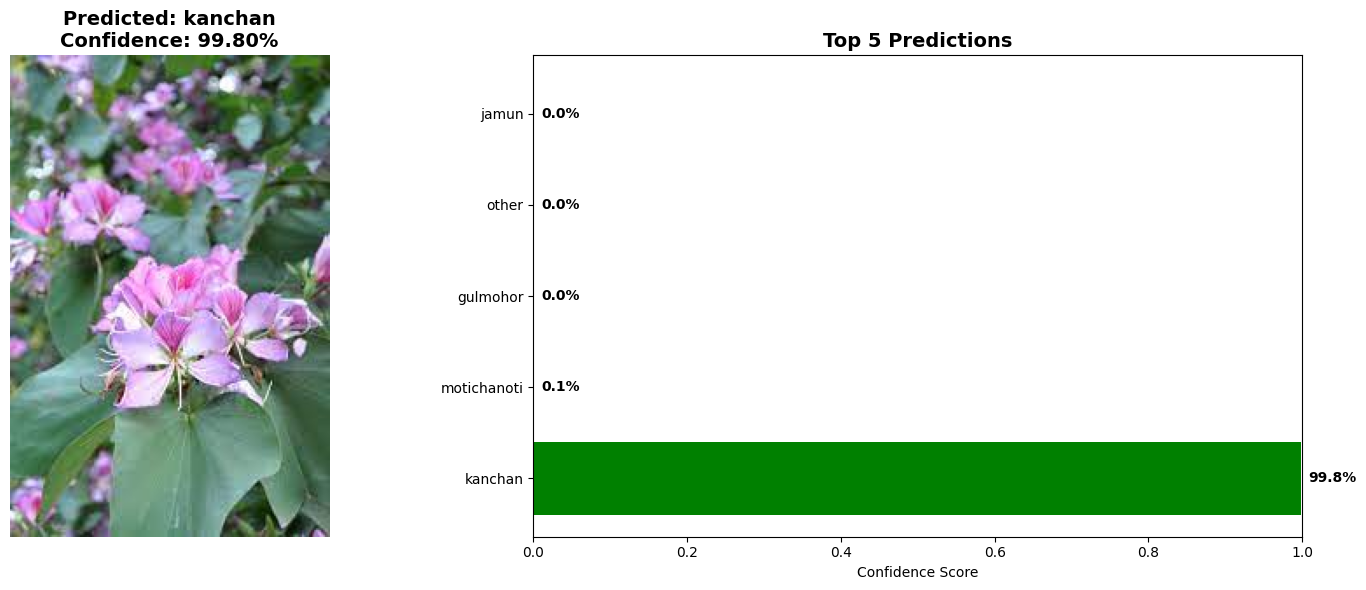

🎯 Prediction Results for data/Tree_Species_Dataset/kanchan/images (12).jpg:
Top prediction: kanchan (99.80%)

Top 5 predictions:
1. kanchan: 0.9980 (99.8%)
2. motichanoti: 0.0011 (0.1%)
3. gulmohor: 0.0005 (0.0%)
4. other: 0.0002 (0.0%)
5. jamun: 0.0001 (0.0%)
✅ Correct!

--- Test 2 ---
Actual species: sonmahor
Image file: images (1).jpeg


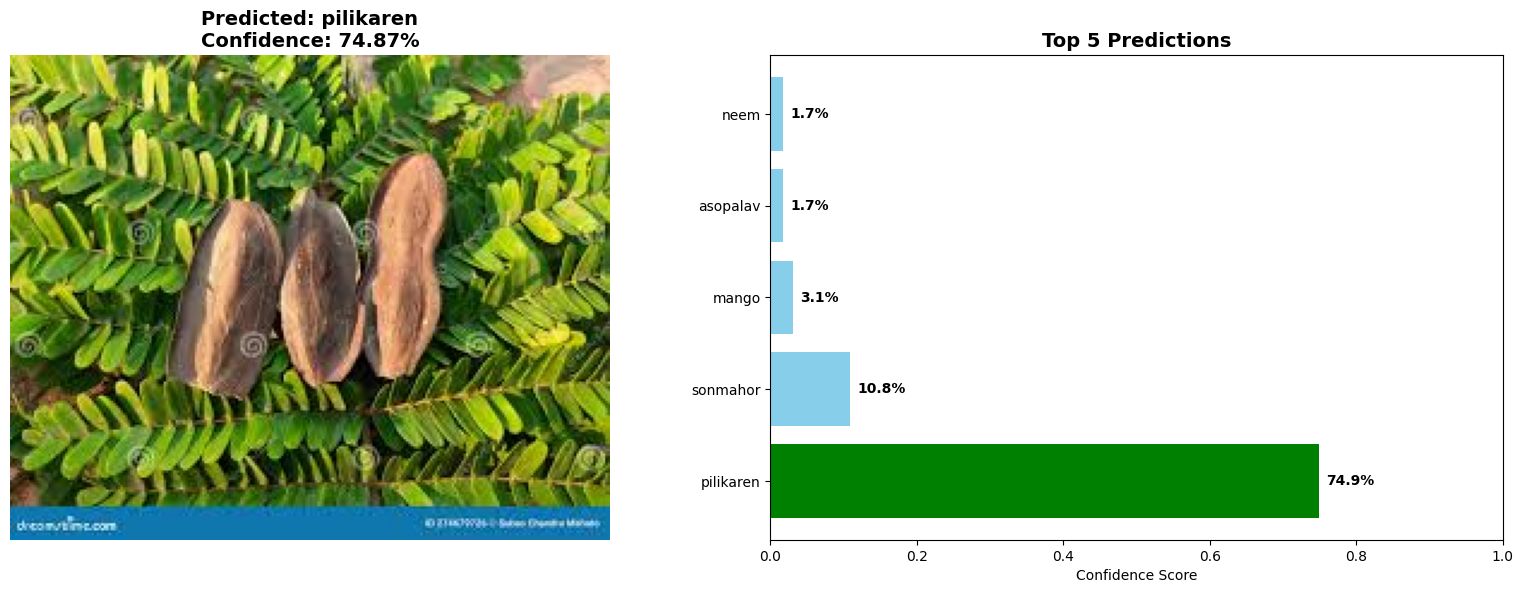

🎯 Prediction Results for data/Tree_Species_Dataset/sonmahor/images (1).jpeg:
Top prediction: pilikaren (74.87%)

Top 5 predictions:
1. pilikaren: 0.7487 (74.9%)
2. sonmahor: 0.1085 (10.8%)
3. mango: 0.0310 (3.1%)
4. asopalav: 0.0172 (1.7%)
5. neem: 0.0169 (1.7%)
❌ Incorrect (actual: sonmahor)

--- Test 3 ---
Actual species: shirish
Image file: images (30).jpeg


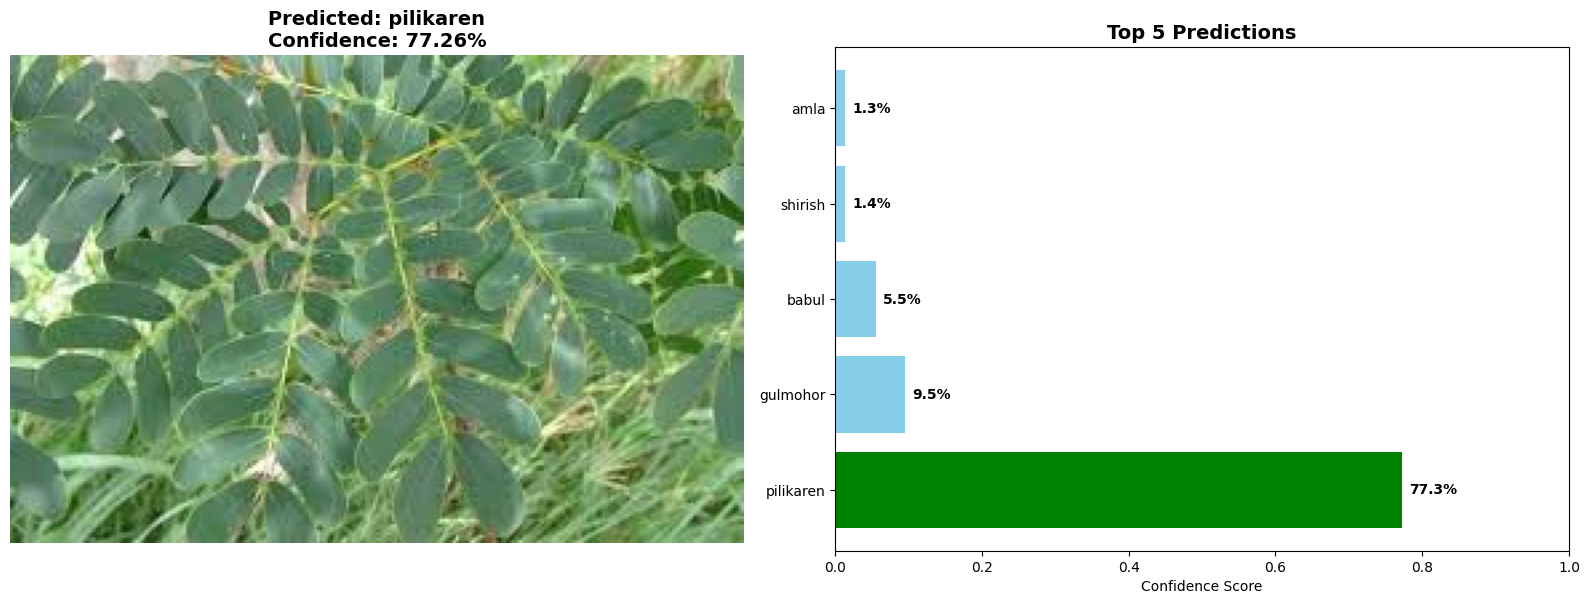

🎯 Prediction Results for data/Tree_Species_Dataset/shirish/images (30).jpeg:
Top prediction: pilikaren (77.26%)

Top 5 predictions:
1. pilikaren: 0.7726 (77.3%)
2. gulmohor: 0.0953 (9.5%)
3. babul: 0.0553 (5.5%)
4. shirish: 0.0141 (1.4%)
5. amla: 0.0133 (1.3%)
❌ Incorrect (actual: shirish)

📋 How to Load and Use the Saved Custom CNN Model:

# Load the saved custom CNN model
import tensorflow as tf

loaded_model = tf.keras.models.load_model('models/custom_cnn_tree_classifier.h5')

# Or load architecture and weights separately
from tensorflow.keras.models import model_from_json

# Load architecture
with open('models/custom_cnn_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load weights
loaded_model.load_weights('models/custom_cnn_weights.weights.h5')

# Use the prediction function
predicted_class, confidence, predictions = predict_tree_species_custom_cnn(
    'path/to/your/tree_image.jpg',
    loaded_mo

In [18]:
import random

def predict_tree_species_custom_cnn(image_path, model, class_names, img_size=224):
    """
    Predict the tree species for a given image using custom CNN
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None, None, None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Make prediction
    predictions = model.predict(img_batch, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]

    # Create detailed visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Display the image with prediction
    ax1.imshow(img)
    ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}',
                  fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Show top 5 predictions as bar chart
    top_5_indices = np.argsort(predictions[0])[-5:][::-1]
    top_5_classes = [class_names[i] for i in top_5_indices]
    top_5_scores = [predictions[0][i] for i in top_5_indices]

    colors = ['green' if i == 0 else 'skyblue' for i in range(5)]
    bars = ax2.barh(top_5_classes, top_5_scores, color=colors)
    ax2.set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Confidence Score')
    ax2.set_xlim(0, 1)

    # Add percentage labels on bars
    for i, (bar, score) in enumerate(zip(bars, top_5_scores)):
        ax2.text(score + 0.01, bar.get_y() + bar.get_height()/2,
                f'{score:.1%}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed predictions
    print(f"🎯 Prediction Results for {image_path}:")
    print(f"Top prediction: {predicted_class} ({confidence:.2%})")
    print(f"\nTop 5 predictions:")
    for i, idx in enumerate(top_5_indices):
        print(f"{i+1}. {class_names[idx]}: {predictions[0][idx]:.4f} ({predictions[0][idx]*100:.1f}%)")

    return predicted_class, confidence, predictions[0]

# Save the final custom CNN model
model.save('models/custom_cnn_tree_classifier.h5')
print("✅ Custom CNN model saved successfully to 'models/custom_cnn_tree_classifier.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open('models/custom_cnn_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✅ Model architecture saved to 'models/custom_cnn_architecture.json'")

# Save model weights separately
model.save_weights('models/custom_cnn_weights.weights.h5')
print("✅ Model weights saved to 'models/custom_cnn_weights.weights.h5'")

# Test prediction on multiple random validation images
print(f"\n🎯 Testing Custom CNN on Random Validation Images:")
print("=" * 60)

# Test on 3 different random images
for test_num in range(3):
    print(f"\n--- Test {test_num + 1} ---")

    # Get a random species and image
    random_species = random.choice(class_names)
    species_path = os.path.join(DATA_DIR, random_species)
    image_files = [f for f in os.listdir(species_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random_image = random.choice(image_files)
    test_image_path = os.path.join(species_path, random_image)

    print(f"Actual species: {random_species}")
    print(f"Image file: {random_image}")

    predicted_class, confidence, all_predictions = predict_tree_species_custom_cnn(
        test_image_path, model, class_names
    )

    # Check if prediction is correct
    is_correct = predicted_class == random_species
    print(f"✅ Correct!" if is_correct else f"❌ Incorrect (actual: {random_species})")

# Create a function to load and use the saved model
print(f"\n📋 How to Load and Use the Saved Custom CNN Model:")
print('''
# Load the saved custom CNN model
import tensorflow as tf

loaded_model = tf.keras.models.load_model('models/custom_cnn_tree_classifier.h5')

# Or load architecture and weights separately
from tensorflow.keras.models import model_from_json

# Load architecture
with open('models/custom_cnn_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load weights
loaded_model.load_weights('models/custom_cnn_weights.weights.h5')

# Use the prediction function
predicted_class, confidence, predictions = predict_tree_species_custom_cnn(
    'path/to/your/tree_image.jpg',
    loaded_model,
    class_names
)
''')

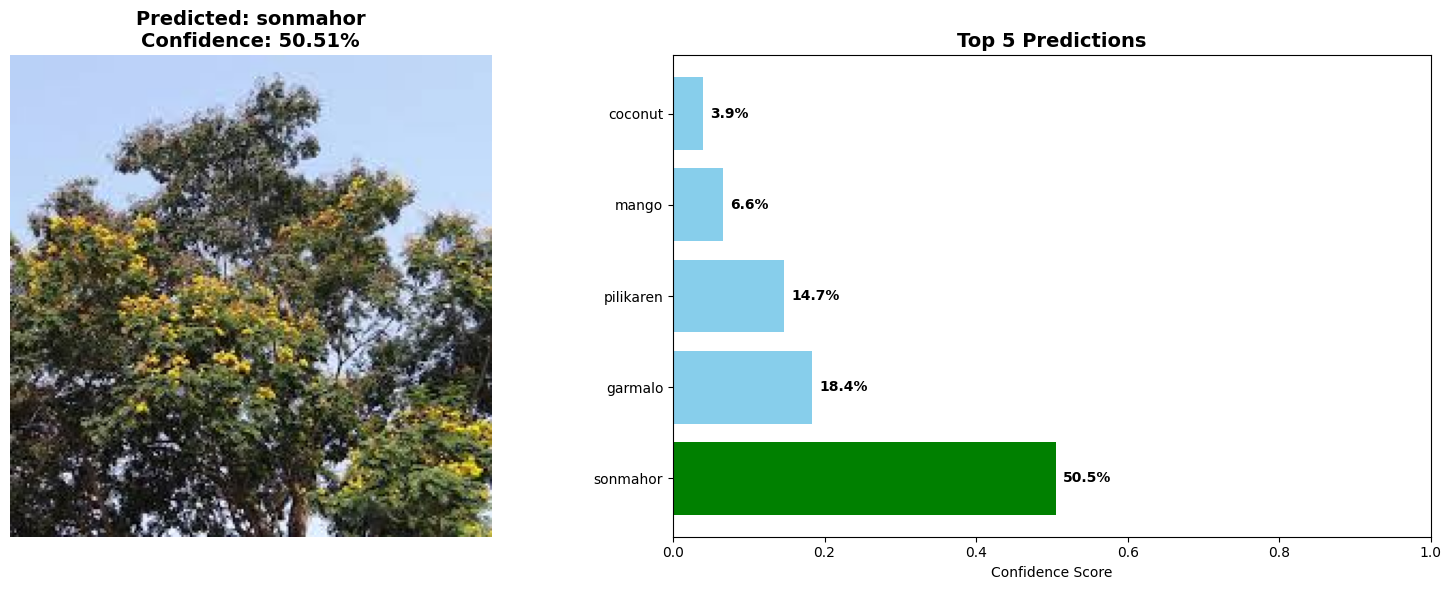

🎯 Prediction Results for /content/data/Tree_Species_Dataset/sonmahor/download (8).jpeg:
Top prediction: sonmahor (50.51%)

Top 5 predictions:
1. sonmahor: 0.5051 (50.5%)
2. garmalo: 0.1838 (18.4%)
3. pilikaren: 0.1469 (14.7%)
4. mango: 0.0657 (6.6%)
5. coconut: 0.0394 (3.9%)


In [34]:
import tensorflow as tf
loaded_model  = tf.keras.models.load_model('models/custom_cnn_tree_classifier.h5')

class_names = [
    'amla', 'asopalav', 'babul', 'bamboo', 'banyan', 'bili',
    'cactus', 'champa', 'coconut', 'garmalo', 'gulmohor',
    'gunda', 'jamun', 'kanchan', 'kesudo', 'khajur', 'mango',
    'motichanoti', 'neem', 'nilgiri', 'other', 'pilikaren',
    'pipal', 'saptaparni', 'shirish', 'simlo', 'sitafal',
    'sonmahor', 'sugarcane', 'vad'
]

predicted_class , confidence , predictions = predict_tree_species_custom_cnn('/content/data/Tree_Species_Dataset/sonmahor/download (8).jpeg',loaded_model,class_names)